# Flu Shot Learning: Predicting H1N1 and Seasonal Flu Vaccines

### Importing requirements

In [84]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

### Loading data

In [85]:
#Opening both datasets with pandas
features = pd.read_csv("training_set_features.csv")
labels = pd.read_csv("training_set_labels.csv")

In [86]:
#Combining the labels with the features
data = pd.concat((features, labels), ignore_index= True)

In [87]:
data.head(15)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,NaN,NaN
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,NaN,NaN
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,NaN,NaN
5,5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Own,Employed,atmpeygn,"MSA, Principle City",2.0,3.0,saaquncn,vlluhbov,NaN,NaN
6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",0.0,0.0,xicduogh,xtkaffoo,NaN,NaN
7,7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Own,Employed,bhuqouqj,Non-MSA,2.0,0.0,pxcmvdjn,xqwwgdyp,NaN,NaN
8,8,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,Own,Employed,bhuqouqj,"MSA, Not Principle City",1.0,0.0,xicduogh,ccgxvspp,NaN,NaN
9,9,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,Own,Not in Labor Force,qufhixun,"MSA, Not Principle City",0.0,0.0,NaN,NaN,NaN,NaN


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53414 entries, 0 to 53413
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                53414 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

We can see the data types available for this dataset are 25 instances of floats, 1 integer and 12 objects.

In [89]:
data.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

In [90]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
respondent_id,53414.0,13353.000000,7709.718984,0.0,6676.25,13353.0,20029.75,26706.0
h1n1_concern,26615.0,1.618486,0.910311,0.0,1.00,2.0,2.00,3.0
h1n1_knowledge,26591.0,1.262532,0.618149,0.0,1.00,1.0,2.00,2.0
behavioral_antiviral_meds,26636.0,0.048844,0.215545,0.0,0.00,0.0,0.00,1.0
behavioral_avoidance,26499.0,0.725612,0.446214,0.0,0.00,1.0,1.00,1.0
behavioral_face_mask,26688.0,0.068982,0.253429,0.0,0.00,0.0,0.00,1.0
behavioral_wash_hands,26665.0,0.825614,0.379448,0.0,1.00,1.0,1.00,1.0
behavioral_large_gatherings,26620.0,0.358640,0.479610,0.0,0.00,0.0,1.00,1.0
behavioral_outside_home,26625.0,0.337315,0.472802,0.0,0.00,0.0,1.00,1.0
behavioral_touch_face,26579.0,0.677264,0.467531,0.0,0.00,1.0,1.00,1.0


In [91]:
data.shape

(53414, 38)

### Checking Duplicates 

In [92]:
data.duplicated().sum()

0

There are no duplicates in this dataset

### Checking missing data

In [93]:
data.isnull().sum()

respondent_id                      0
h1n1_concern                   26799
h1n1_knowledge                 26823
behavioral_antiviral_meds      26778
behavioral_avoidance           26915
behavioral_face_mask           26726
behavioral_wash_hands          26749
behavioral_large_gatherings    26794
behavioral_outside_home        26789
behavioral_touch_face          26835
doctor_recc_h1n1               28867
doctor_recc_seasonal           28867
chronic_med_condition          27678
child_under_6_months           27527
health_worker                  27511
health_insurance               38981
opinion_h1n1_vacc_effective    27098
opinion_h1n1_risk              27095
opinion_h1n1_sick_from_vacc    27102
opinion_seas_vacc_effective    27169
opinion_seas_risk              27221
opinion_seas_sick_from_vacc    27244
age_group                      26707
education                      28114
race                           26707
sex                            26707
income_poverty                 31130
m

In [94]:
data.isnull().sum()/len(data)*100

respondent_id                   0.000000
h1n1_concern                   50.172239
h1n1_knowledge                 50.217172
behavioral_antiviral_meds      50.132924
behavioral_avoidance           50.389411
behavioral_face_mask           50.035571
behavioral_wash_hands          50.078631
behavioral_large_gatherings    50.162879
behavioral_outside_home        50.153518
behavioral_touch_face          50.239638
doctor_recc_h1n1               54.043884
doctor_recc_seasonal           54.043884
chronic_med_condition          51.817875
child_under_6_months           51.535178
health_worker                  51.505223
health_insurance               72.978994
opinion_h1n1_vacc_effective    50.732018
opinion_h1n1_risk              50.726401
opinion_h1n1_sick_from_vacc    50.739506
opinion_seas_vacc_effective    50.864942
opinion_seas_risk              50.962295
opinion_seas_sick_from_vacc    51.005354
age_group                      50.000000
education                      52.634141
race            

We can see that nearly all of the data has over 50% of missing data with employment occupation being the highest with 75%

Our dataset is quite imbalanced so we can impute this missing data to balance it out

### Imputation of the missing data

In [95]:
#Assigning the numerical data to a variable
numeric_data = data._get_numeric_data()

In [96]:
#Imputing Numerical Data with the median
for column in numeric_data:
    data[column].fillna(data[column].median(), inplace= True)

In [97]:
data.isnull().sum()/len(data)*100


respondent_id                   0.000000
h1n1_concern                    0.000000
h1n1_knowledge                  0.000000
behavioral_antiviral_meds       0.000000
behavioral_avoidance            0.000000
behavioral_face_mask            0.000000
behavioral_wash_hands           0.000000
behavioral_large_gatherings     0.000000
behavioral_outside_home         0.000000
behavioral_touch_face           0.000000
doctor_recc_h1n1                0.000000
doctor_recc_seasonal            0.000000
chronic_med_condition           0.000000
child_under_6_months            0.000000
health_worker                   0.000000
health_insurance                0.000000
opinion_h1n1_vacc_effective     0.000000
opinion_h1n1_risk               0.000000
opinion_h1n1_sick_from_vacc     0.000000
opinion_seas_vacc_effective     0.000000
opinion_seas_risk               0.000000
opinion_seas_sick_from_vacc     0.000000
age_group                      50.000000
education                      52.634141
race            

We've now replaced the numerical data with the median of each column

In [98]:
#Assigned the columns with categorical data to a variable
categorical_data = ['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','hhs_geo_region','census_msa'
               ,'employment_industry','employment_occupation']

In [99]:
#Imputing the categorical data with the mode of each column
for column in categorical_data:
    data[column].fillna(data[column].mode()[0], inplace=True)

In [100]:
data.isnull().sum()/len(data)*100

respondent_id                  0.0
h1n1_concern                   0.0
h1n1_knowledge                 0.0
behavioral_antiviral_meds      0.0
behavioral_avoidance           0.0
behavioral_face_mask           0.0
behavioral_wash_hands          0.0
behavioral_large_gatherings    0.0
behavioral_outside_home        0.0
behavioral_touch_face          0.0
doctor_recc_h1n1               0.0
doctor_recc_seasonal           0.0
chronic_med_condition          0.0
child_under_6_months           0.0
health_worker                  0.0
health_insurance               0.0
opinion_h1n1_vacc_effective    0.0
opinion_h1n1_risk              0.0
opinion_h1n1_sick_from_vacc    0.0
opinion_seas_vacc_effective    0.0
opinion_seas_risk              0.0
opinion_seas_sick_from_vacc    0.0
age_group                      0.0
education                      0.0
race                           0.0
sex                            0.0
income_poverty                 0.0
marital_status                 0.0
rent_or_own         

### Seperating categorical and numerical data

In [101]:
cat=[]
num=[]
for i in data.columns:
    if data[i].dtype=="object":
        cat.append(i)
    else:
        num.append(i)

In [102]:
print(cat)

['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']


In [103]:
print(num)

['respondent_id', 'h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children', 'h1n1_vaccine', 'seasonal_vaccine']


### Dealing with outliers

<AxesSubplot:>

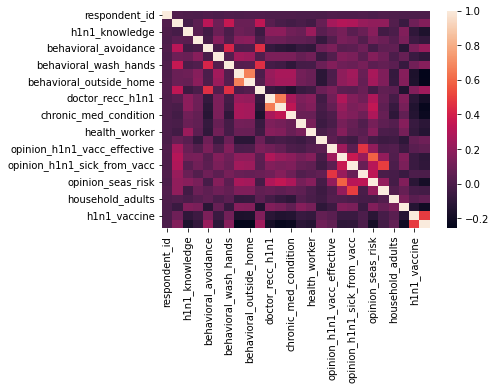

In [104]:
sns.heatmap(data.corr())

In [105]:
#We can remove respondent_id since it is deemed redundant
data.drop(['respondent_id'], axis = 1, inplace=True)

In [106]:
sns.distplot(data["SalePrice"])

KeyError: 'SalePrice'